#### Imports / configuration loading

In [1]:
# # Reload imports if needed
# import source
# import importlib
# importlib.reload(source.results_analysis)
# importlib.reload(source.train_predictive_models)
# importlib.reload(source.predictive_models)

In [2]:

from source import agents, exploration, predictive_models
from source.map_loader import Env
from source.train_predictive_models import process_input, runSGD, one_hot_encode
from source.results_analysis import metrics_predict_map,print_metrics,latent_space_PCA
from pathlib import Path
import source.results_analysis as results_analysis
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import json
import os
import textwrap

CONFIG_NAME = "allocentric_8x8_empty_inputs.json"

with open(f"configs/exploring_latent_space/{CONFIG_NAME}", 'r') as file:
    config = json.load(file)

####  Environment creation

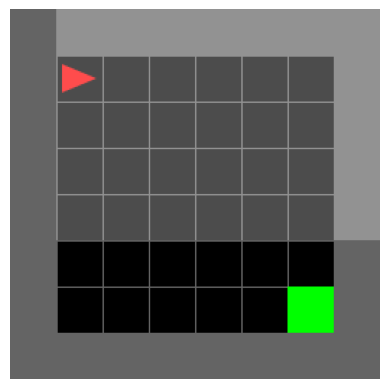

In [3]:
with open(f"maps/{config['map_path']}", 'r') as file:
    map = [[int(x) for x in line.strip().split(" ")] for line in file ]

env = Env(map,config['map_dims'],tuple(config['start_pos']),seed=config['env_seed'],render_mode="rgb_array",agent_view_size=config['egocentric_view_size'])

env.reset(seed=env.env_seed)
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [4]:
 env.gen_obs()['image'][:,:,0]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1]], dtype=uint8)

#### Environment exploration


In [5]:
if (config['observation_space'] == "egocentric"):
    image_list_train, pos_list_train, dir_list_train, image_list_test, pos_list_test, dir_list_test = exploration.exploration_egocentric(
            env,
            agent_type=config['agent_type'],
            n_steps_train=config['number_steps_train'],
            n_steps_test=config['number_steps_test'],
            n_restart_train=config['num_random_position_restarts_train'],
            n_restart_test=config['num_random_position_restarts_test'])

elif (config['observation_space'] == "allocentric"):
    image_list_train, pos_list_train, dir_list_train, image_list_test, pos_list_test, dir_list_test= exploration.exploration_allocentric(
            env,
            agent_type=config['agent_type'],
            n_steps_train=config['number_steps_train'],
            n_steps_test=config['number_steps_test'],
            n_restart_train=config['num_random_position_restarts_train'],
            n_restart_test=config['num_random_position_restarts_test'])

#### Predictive model training

In [6]:
X_train, X_test = image_list_train, image_list_test 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)

scaling_factor=10

if config["observation_space"]=="allocentric":
    img_width, img_height = env.width, env.height
else:
    img_width, img_height = env.unwrapped.agent_view_size, env.unwrapped.agent_view_size

input_train_processed = torch.stack([process_input(x, 'in',img_width,img_height,scaling_factor) for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in',img_width,img_height,scaling_factor) for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out',img_width,img_height,scaling_factor) for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out',img_width,img_height,scaling_factor) for x in target_test])

print(target_train_processed)
print(input_train_processed)

latent_size=config["latent_size"]
hidden_fac=15
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
torch.manual_seed(config["model_seed"])
torch.use_deterministic_algorithms(True)
train_flag = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if config['model_type'] == "autoencoder_no_rnn":
    model = predictive_models.AutoencoderWithoutRNN(input_size, output_size, hidden_fac, latent_size,device)
elif config["model_type"]=="autoencoder_rnn":
    model = predictive_models.AutoencoderWithRNN(input_size, output_size, hidden_fac, latent_size,device)
elif config["model_type"]=="autoencoder_rnn_separate_action":
    model = predictive_models.AutoencoderRNNSeparateAction(img_width*img_height,input_size-img_width*img_height, output_size, hidden_fac, latent_size,device)
else:
    model = predictive_models.AutoencoderInputs(img_width*img_height,device)
    train_flag = False
n_epochs, batch_size = config['number_epochs'], config['batch_size']
MODEL_PATH = f"trained_models/exploring_latent_space/{config['predictive_model_path']}.pt"
if (config["load_trained_model_if_existent"] and os.path.exists(MODEL_PATH)) and config["model_type"]!="inputs":
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
        print("Loaded model!")
        with open(f"outputs/exploring_latent_space/model_evaluation/{config['config_name']}.json", "r") as f:
            metrics = json.load(f)
        train_flag = False
    except (RuntimeError, KeyError, EOFError) as e:
        print("Failed to load model - will proceed to training!")
if train_flag:
    tracked_losses_train, tracked_losses_test = runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, device=device, n_epochs=n_epochs, batch_size=batch_size,seed=config["model_seed"],notrain=(not config["train"]))
    if (config['save_trained_model']):
        torch.save(model.state_dict(), MODEL_PATH)


/tmp/ipykernel_85754/277067962.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  target_train = torch.tensor(target_train, dtype=torch.int64)
/home/likescience/SURFIN/predictive_model_latent_space/source/train_predictive_models.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  world_map = torch.tensor(input_array[:-1]).float()
/home/likescience/SURFIN/predictive_model_latent_space/source/train_predictive_models.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ret

tensor([[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]])
tensor([[0.2000, 0.2000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.0000, 1.0000, 0.0000],
        [0.2000, 0.2000, 0.2000,  ..., 0.0000, 1.0000, 0.0000],
        [0.2000, 0.2000, 0.2000,  ..., 0.0000, 0.0000, 0.0000]])


#### Metrics

In [ ]:
if (config["compute_metrics"]):
    if train_flag:
        dec_outputs = metrics_predict_map(env,model,config,device,scaling_factor,input_test_processed,target_test,tracked_losses_train,tracked_losses_test)

        input_grids, output_grids, target_grids = [],[],[]
        for i in range(config["range_images_of_predictions_to_save"][0],config["range_images_of_predictions_to_save"][1]+1): 
            # Print the input, decoded grid, and target test grid side by side
            print(f"Sample {i + 1}:")
            
            action = input_test[i, img_width*img_height].item()

            # Input grid 
            print("Input Grid:")
            input_grid=input_test[i, :img_width*img_height].reshape(img_width, img_height).int()
            print(input_grid)
            # input_grid = [str(row.tolist()) for row in input_grid]
            input_grids.append(input_grid.tolist()+[action])
            
            # Decoded /output grid 
            print("Output Grid:")
            output_grid = dec_outputs[i, :img_width*img_height].reshape(img_width, img_height).int()
            print(output_grid)
            # output_grid = [str(row.tolist()) for row in output_grid]
            output_grids.append(output_grid.tolist()+[action])
            
            # Target grid 
            print("Target Grid:")
            target_grid = target_test[i, :img_width*img_height].reshape(img_width, img_height).int()
            print(target_grid)
            # target_grid = [str(row.tolist()) for row in target_grid]
            target_grids.append(target_grid.tolist()+[action])

            # Provided action 
            print(f"Input Action: {action}")
            
            print("=" * 50)  # Separator
            with open(f"outputs/exploring_latent_space/saved_grids/{config['config_name']}.json", "w") as f:
                grids_to_save = {"input":input_grids,"output":output_grids,"target":target_grids}
                f.write(__import__('re').sub(r'\[\s+([\d,\s\-.]+)\s+\]', lambda m: m.group(0).replace('\n', '').replace(' ', '').replace(',', ', '), json.dumps(grids_to_save, indent=4)))
    else:
        print_metrics(config,metrics)

NameError: name 'tracked_losses_train' is not defined

#### Grid search

In [ ]:
#Currently only implemented for one dimension (size of latent space)
if config["run_grid_search"] and len(config["grid_search"])>0:
    if config["grid_search"][0] == "latent_space_size":
        bottlenecks = config["grid_search"][1]
        last_losses = []

        for b in bottlenecks:
            
            if config['model_type'] == "autoencoder_no_rnn":
                model = predictive_models.AutoencoderWithoutRNN(input_size, output_size, hidden_fac, b,device)
            elif config["model_type"]=="autoencoder_rnn":
                model = predictive_models.AutoencoderWithRNN(input_size, output_size, hidden_fac, b,device)
            elif config["model_type"]=="autoencoder_rnn_separate_action":
                model = predictive_models.AutoencoderRNNSeparateAction(img_width*img_height,input_size-img_width*img_height, output_size, hidden_fac, b,device)

            n_epochs = 20
            batch_size = 256

            _, tracked_losses_test = runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size,device=device)
            last_losses.append(tracked_losses_test[-1])

        obs_space, has_rnn = config['observation_space'], 'without' if config["model_type"] =="autoencoder_no_rnn" else 'with'
        plt.scatter(x=bottlenecks, y=np.log10(last_losses), )
        plt.title(f"log10 of loss after {n_epochs} epochs over latent space size for the autoencoder\n with an {obs_space} world view and {has_rnn} an RNN in latent space")
        plt.xlabel("Size of latent space")
        plt.ylabel(f"log10 of loss after {n_epochs} epochs")
        plt.savefig(f"outputs/exploring_latent_space/grid_search/latent_size_{obs_space}_{has_rnn}_RNN.png")


#### PCA on latent space 

In [8]:
if (config["perform_PCA_latent_space"]):
    latent_space_before, latent_space_after = model.get_latent(input_train_processed)

    if (config["model_type"] == "autoencoder_rnn"):
        latent_spaces = [[latent_space_before, "before_RNN"],[latent_space_after, "after_RNN"]]
    else:
        latent_spaces = [[latent_space_before, ""]]

    latent_space_PCA(latent_spaces,config,pos_list_train[:-1],dir_list_train[:-1],img_width,img_height)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
#If model isnt trained, we also look for these representations without providing the action:
if (config["perform_PCA_latent_space"]):
    if (not config["train"] and config["model_type"] != "inputs"):
        if (config["model_type"] == "autoencoder_no_rnn"):
            model_noaction = predictive_models.AutoencoderWithoutRNN(output_size, output_size, hidden_fac, latent_size,device)
        elif (config["model_type"] == "autoencoder_rnn"):
            model_noaction = predictive_models.AutoencoderWithRNN(output_size, output_size, hidden_fac, latent_size,device)
        else:
            pass
        latent_space_before, latent_space_after = model_noaction.get_latent(target_train_processed) # THe target has no action, and the observations are essentially the same but just with offset of 1

        if (config["model_type"] != "autoencoder_no_rnn"):
            latent_spaces = [[latent_space_before, "before_RNN_noaction"],[latent_space_after, "after_RNN_noaction"]]
        else:
            latent_spaces = [[latent_space_before, "noaction"]]

        latent_space_PCA(latent_spaces,config,pos_list_train[1:],dir_list_train[1:],img_width,img_height)

#### Training a two-layer decoder to decode latent space representations

In [7]:
latent_space_before_train, latent_space_after_train = model.get_latent(input_train_processed)
latent_space_before_test, latent_space_after_test = model.get_latent(input_test_processed)

if (config["model_type"] == "autoencoder_rnn"):
    latent_size_repr = latent_size
    latent_representations_train = [[latent_space_before_train.detach(), "_before_RNN"],[latent_space_after_train.detach(), "_after_RNN"]]
    latent_representations_test = [[latent_space_before_test.detach(), "_before_RNN"],[latent_space_after_test.detach(), "_after_RNN"]]
elif (config["model_type"] == "autoencoder_no_rnn"):
    latent_size_repr = latent_size
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]
elif (config["model_type"] == "autoencoder_rnn_separate_action"):
    latent_size_repr = latent_size-(input_size-img_height*img_width)
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]
elif (config["model_type"] == "inputs"):
    latent_size_repr = img_height*img_width
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]
for i in range(len(latent_representations_train)):
    latent_representation_train, label = latent_representations_train[i]
    latent_representation_test, label = latent_representations_test[i]
    dict_repr = {}
    for variable in config["variables_for_training_decoder"]:
        if variable == "position":
            target_train_repr, target_test_repr = torch.tensor(pos_list_train[:-1]).float(), torch.tensor(pos_list_test[:-1]).float()
            decoder_model = predictive_models.LinearDecoder(2,30,latent_size_repr)
            loss_type="mse"
            metric, metric_label, output_process = results_analysis.accuracy, "accuracy",results_analysis.round
        elif variable == "L2_dist_center":
            target_train_repr = torch.tensor(np.sqrt((np.array(pos_list_train)[:-1,0]-(img_width-1)/2)**2+ (np.array(pos_list_train)[:-1,1]-(img_height-1)/2)**2)).float().unsqueeze(-1)
            target_test_repr = torch.tensor(np.sqrt((np.array(pos_list_test)[:-1,0]-(img_width-1)/2)**2+ (np.array(pos_list_test)[:-1,1]-(img_height-1)/2)**2)).float().unsqueeze(-1)
            loss_type="mse"
            decoder_model = predictive_models.LinearDecoder(1,30,latent_size_repr)
            metric, metric_label, output_process = results_analysis.mse, "mse",results_analysis.identity
        elif variable == "head_direction":
            target_train_repr, target_test_repr = torch.tensor(dir_list_train[:-1]).long().view(-1), torch.tensor(dir_list_test[:-1]).long().view(-1)
            decoder_model = predictive_models.LinearDecoder(4,30,latent_size_repr)
            loss_type="cel"
            metric, metric_label, output_process = results_analysis.accuracy, "accuracy", results_analysis.argmax
            # target_train_repr, target_test_repr = torch.stack([one_hot_encode(i,4) for i in dir_list_train[:-1]]).float(), torch.stack([one_hot_encode(i,4) for i in dir_list_test[:-1]]).float()
            # decoder_model = predictive_models.LinearDecoder(4,30,latent_size_repr)
            # metric, metric_label, output_process = results_analysis.accuracy, "accuracy", results_analysis.round
        tracked_losses_train_repr, tracked_losses_test_repr = runSGD(decoder_model,latent_representation_train,target_train_repr,latent_representation_test,target_test_repr,device,n_epochs=100,criterion=loss_type,batch_size=256,shuffle=False,hide_plot=True)
        output_test_repr = decoder_model(latent_representation_test)
        output_test_repr = output_process(output_test_repr)
        results_repr = {}
        results_repr["name"] = f"{config['config_name']}{label}"
        results_repr["metric"] = metric(output_test_repr, target_test_repr)
        results_repr["metric_name"] = metric_label
        results_repr["tracked_losses_test"] = tracked_losses_test_repr
        dict_repr[variable] = results_repr
        print(results_repr)
    with open(f"outputs/exploring_latent_space/decode_latent_representations_2layer/{config['config_name']}{label}.json", "w") as f:
        json.dump(dict_repr, f, indent=4)



Epoch 	 Loss train 	 Loss test
1/100	 9.8439		 11.1276
2/100	 4.2274		 4.7365


/home/likescience/SURFIN/predictive_model_latent_space/source/train_predictive_models.py:122: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  track_loss += [float(loss)]


3/100	 2.8799		 2.7694
4/100	 2.8150		 2.6997
5/100	 2.7505		 2.6524
6/100	 2.6827		 2.5843
7/100	 2.6140		 2.5187
8/100	 2.5434		 2.4509
9/100	 2.4708		 2.3812
10/100	 2.3957		 2.3092
11/100	 2.3179		 2.2344
12/100	 2.2371		 2.1567
13/100	 2.1530		 2.0756
14/100	 2.0653		 1.9910
15/100	 1.9740		 1.9026
16/100	 1.8789		 1.8104
17/100	 1.7803		 1.7144
18/100	 1.6783		 1.6150
19/100	 1.5735		 1.5124
20/100	 1.4664		 1.4076
21/100	 1.3580		 1.3029
22/100	 1.2493		 1.1957
23/100	 1.1414		 1.0894
24/100	 1.0360		 0.9830
25/100	 0.9335		 0.8808
26/100	 0.8356		 0.7839
27/100	 0.7433		 0.6923
28/100	 0.6579		 0.6080
29/100	 0.5799		 0.5304
30/100	 0.5100		 0.4611
31/100	 0.4483		 0.3994
32/100	 0.3948		 0.3466
33/100	 0.3493		 0.3012
34/100	 0.3112		 0.2638
35/100	 0.2797		 0.2327
36/100	 0.2541		 0.2079
37/100	 0.2336		 0.1880
38/100	 0.2173		 0.1724
39/100	 0.2044		 0.1602
40/100	 0.1942		 0.1507
41/100	 0.1861		 0.1434
42/100	 0.1798		 0.1378
43/100	 0.1747		 0.1334
44/100	 0.1705		 0.1299

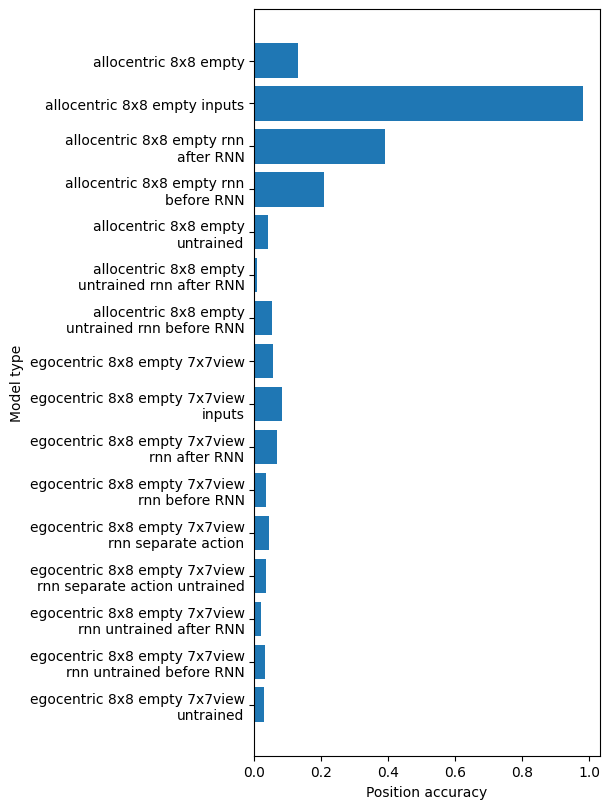

<Figure size 640x480 with 0 Axes>

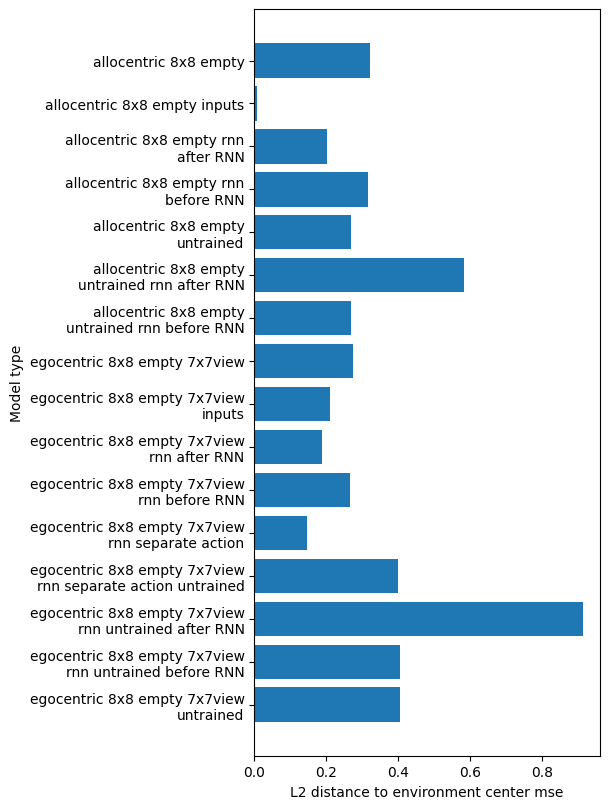

<Figure size 640x480 with 0 Axes>

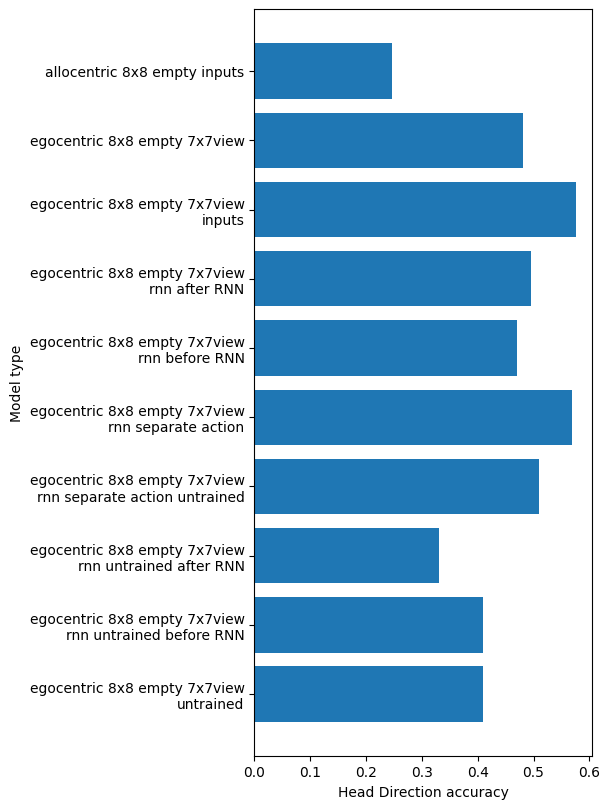

<Figure size 640x480 with 0 Axes>

In [8]:
directory = 'outputs/exploring_latent_space/decode_latent_representations_2layer'
dirs_to_exclude = {"head_direction": ["allocentric_8x8_empty_rnn", "allocentric_8x8_empty_untrained_rnn","allocentric_8x8_empty_untrained","allocentric_8x8_empty.json"] }
target_vars = ["position","L2_dist_center", "head_direction"]
target_vars_labels = {"position": "Position", "L2_dist_center":"L2 distance to environment center","head_direction": "Head Direction" }

for target_var in target_vars: 
    labels = []
    values = []
    metric_label = ""
    for filename in sorted(os.listdir(directory),reverse=True):
        if filename.endswith('.json'):
            if (target_var in dirs_to_exclude.keys() and filename.startswith(tuple(dirs_to_exclude[target_var]))):
                continue
            path = os.path.join(directory, filename)
            with open(path, 'r') as f:
                data = json.load(f)
                if target_var in data:
                    metric_label = data[target_var]["metric_name"]
                    values += [data[target_var]["metric"]]
                    labels += [data[target_var]["name"].replace("_", " ")]
    wrapped_labels = [textwrap.fill(label, width=30) for label in labels]
    plt.figure(figsize=(6, 8))
    plt.barh(wrapped_labels,values)
    plt.tight_layout()
    plt.ylabel('Model type')
    plt.xlabel(f"{target_vars_labels[target_var]} {metric_label}")
    plt.savefig(f"outputs/exploring_latent_space/decode_latent_representations_2layer/{target_var}.png", bbox_inches='tight')
    plt.show()
    plt.clf()


#### Training a single-layer decoder to decode latent space representaitons

In [9]:
latent_space_before_train, latent_space_after_train = model.get_latent(input_train_processed)
latent_space_before_test, latent_space_after_test = model.get_latent(input_test_processed)

if (config["model_type"] == "autoencoder_rnn"):
    latent_size_repr = latent_size
    latent_representations_train = [[latent_space_before_train.detach(), "_before_RNN"],[latent_space_after_train.detach(), "_after_RNN"]]
    latent_representations_test = [[latent_space_before_test.detach(), "_before_RNN"],[latent_space_after_test.detach(), "_after_RNN"]]
elif (config["model_type"] == "autoencoder_no_rnn"):
    latent_size_repr = latent_size
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]
elif (config["model_type"] == "autoencoder_rnn_separate_action"):
    latent_size_repr = latent_size-(input_size-img_height*img_width)
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]
elif (config["model_type"] == "inputs"):
    latent_size_repr = img_height*img_width
    latent_representations_train = [[latent_space_before_train.detach(), ""]]
    latent_representations_test = [[latent_space_before_test.detach(), ""]]

dads = []
for i in range(len(latent_representations_train)):
    latent_representation_train, label = latent_representations_train[i]
    latent_representation_test, label = latent_representations_test[i]
    dict_repr = {}
    for variable in config["variables_for_training_decoder"]:
        if variable == "position":
                target_train_repr, target_test_repr = torch.tensor(pos_list_train[:-1]).float(), torch.tensor(pos_list_test[:-1]).float()
                decoder_model = nn.Linear(latent_size_repr,2)
                loss_type="mse"
                metric, metric_label, output_process = results_analysis.accuracy, "accuracy",results_analysis.round
        elif variable == "L2_dist_center":
            target_train_repr = torch.tensor(np.sqrt((np.array(pos_list_train)[:-1,0]-(img_width-1)/2)**2+ (np.array(pos_list_train)[:-1,1]-(img_height-1)/2)**2)).float().unsqueeze(-1)
            target_test_repr = torch.tensor(np.sqrt((np.array(pos_list_test)[:-1,0]-(img_width-1)/2)**2+ (np.array(pos_list_test)[:-1,1]-(img_height-1)/2)**2)).float().unsqueeze(-1)
            decoder_model = nn.Linear(latent_size_repr,1)
            loss_type="mse"
            metric, metric_label, output_process = results_analysis.mse, "mse",results_analysis.identity
        elif variable == "head_direction":
            target_train_repr, target_test_repr = torch.tensor(dir_list_train[:-1]).long().view(-1), torch.tensor(dir_list_test[:-1]).long().view(-1)
            decoder_model = nn.Linear(latent_size_repr,4)
            loss_type="cel"
            metric, metric_label, output_process = results_analysis.accuracy, "accuracy", results_analysis.argmax
            # target_train_repr, target_test_repr = torch.stack([one_hot_encode(i,4) for i in dir_list_train[:-1]]).float(), torch.stack([one_hot_encode(i,4) for i in dir_list_test[:-1]]).float()
            # decoder_model =nn.Linear(latent_size_repr,4)
            # loss_type="mse"
            # metric, metric_label, output_process = results_analysis.accuracy, "accuracy", results_analysis.round
        tracked_losses_train_repr, tracked_losses_test_repr = runSGD(decoder_model,latent_representation_train,target_train_repr,latent_representation_test,target_test_repr,device,criterion=loss_type,n_epochs=100,batch_size=256,shuffle=False,hide_plot=True,lr=.01)
        output_test_repr = decoder_model(latent_representation_test)
        output_test_repr = output_process(output_test_repr)
        results_repr = {}
        results_repr["name"] = f"{config['config_name']}{label}"
        results_repr["metric"] = metric(output_test_repr, target_test_repr)
        results_repr["metric_name"] = metric_label
        results_repr["tracked_losses_test"] = tracked_losses_test_repr
        dict_repr[variable] = results_repr
        print(results_repr)
        print(decoder_model.weight.grad.abs().mean())
        dads += [output_test_repr,target_test_repr]
        
    with open(f"outputs/exploring_latent_space/decode_latent_representations_1layer/{config['config_name']}{label}.json", "w") as f:
        json.dump(dict_repr, f, indent=4)


Epoch 	 Loss train 	 Loss test
1/100	 3.0880		 3.2584
2/100	 2.7300		 2.5544
3/100	 2.5353		 2.4452
4/100	 2.3420		 2.2516
5/100	 2.1516		 2.0661
6/100	 1.9669		 1.8870
7/100	 1.7908		 1.7156
8/100	 1.6248		 1.5540
9/100	 1.4699		 1.4030
10/100	 1.3265		 1.2631
11/100	 1.1947		 1.1343
12/100	 1.0742		 1.0164
13/100	 0.9646		 0.9092
14/100	 0.8655		 0.8122
15/100	 0.7763		 0.7248
16/100	 0.6963		 0.6464
17/100	 0.6250		 0.5764
18/100	 0.5616		 0.5142
19/100	 0.5055		 0.4591
20/100	 0.4560		 0.4106
21/100	 0.4125		 0.3679
22/100	 0.3745		 0.3306
23/100	 0.3413		 0.2981
24/100	 0.3125		 0.2699
25/100	 0.2875		 0.2455
26/100	 0.2659		 0.2244
27/100	 0.2473		 0.2063
28/100	 0.2314		 0.1908
29/100	 0.2177		 0.1776
30/100	 0.2060		 0.1663
31/100	 0.1960		 0.1567
32/100	 0.1874		 0.1486
33/100	 0.1801		 0.1417
34/100	 0.1738		 0.1359
35/100	 0.1685		 0.1309
36/100	 0.1639		 0.1267
37/100	 0.1599		 0.1231
38/100	 0.1565		 0.1200
39/100	 0.1535		 0.1174
40/100	 0.1508		 0.1151
41/100	 0.1484		 0

In [10]:
# torch.set_printoptions(threshold=float('inf'))
# print(*[f"{dads[4][i].tolist()} {dads[5][i].tolist()}" for i in range(30)], sep='\n')
# # print(input_test[:,:49].reshape(1999,7,7)[:30])
# print(input_test[:,:49].reshape(1999,7,7)[:30])

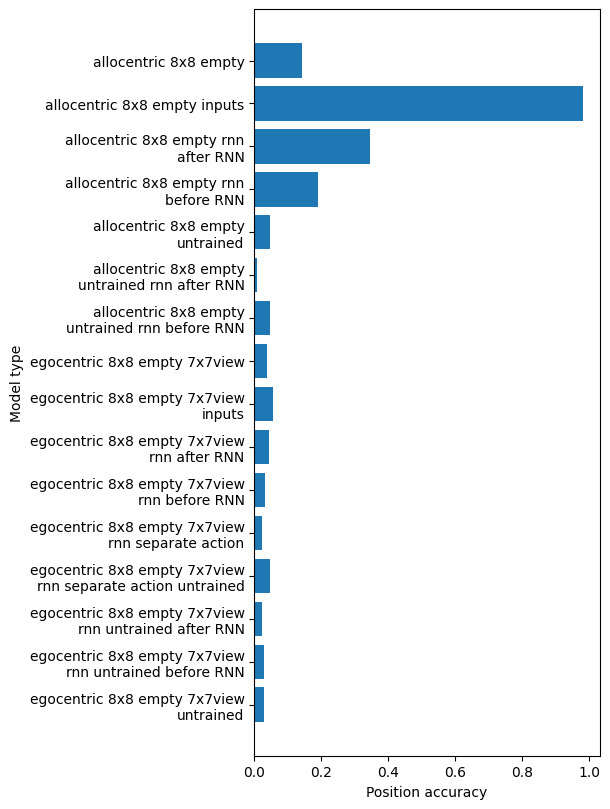

<Figure size 640x480 with 0 Axes>

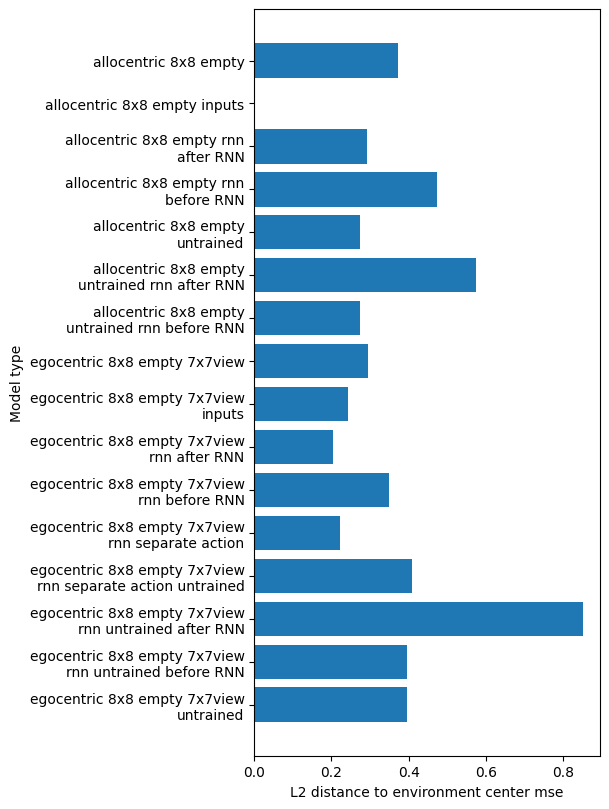

<Figure size 640x480 with 0 Axes>

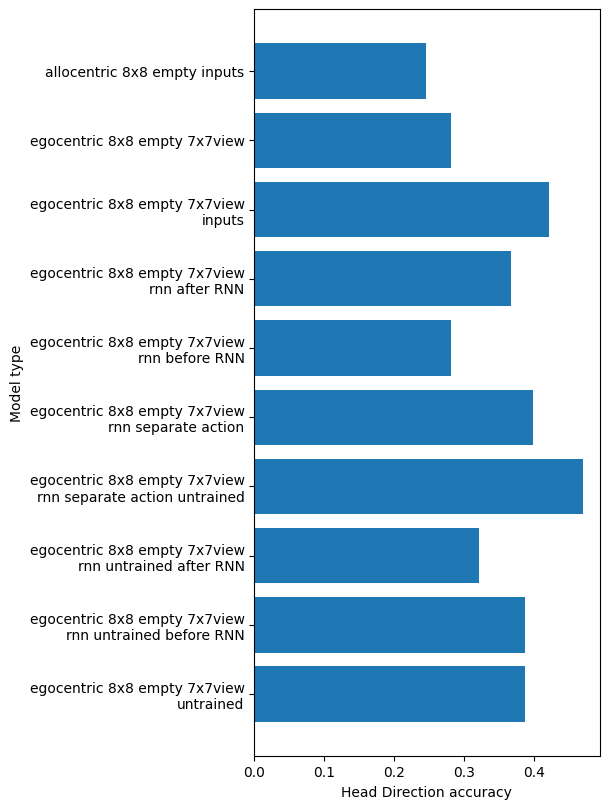

<Figure size 640x480 with 0 Axes>

In [11]:
directory = 'outputs/exploring_latent_space/decode_latent_representations_1layer'
dirs_to_exclude = {"head_direction": ["allocentric_8x8_empty_rnn", "allocentric_8x8_empty_untrained_rnn","allocentric_8x8_empty_untrained","allocentric_8x8_empty.json"] }
target_vars = ["position","L2_dist_center", "head_direction"]
target_vars_labels = {"position": "Position", "L2_dist_center":"L2 distance to environment center","head_direction": "Head Direction" }

for target_var in target_vars: 
    labels = []
    values = []
    metric_label = ""
    for filename in sorted(os.listdir(directory),reverse=True):
        if filename.endswith('.json'):
            if (target_var in dirs_to_exclude.keys() and filename.startswith(tuple(dirs_to_exclude[target_var]))):
                continue
            path = os.path.join(directory, filename)
            with open(path, 'r') as f:
                data = json.load(f)
                if target_var in data:
                    metric_label = data[target_var]["metric_name"]
                    values += [data[target_var]["metric"]]
                    labels += [data[target_var]["name"].replace("_", " ")]
    wrapped_labels = [textwrap.fill(label, width=30) for label in labels]
    plt.figure(figsize=(6, 8))
    plt.barh(wrapped_labels,values)
    plt.tight_layout()
    plt.ylabel('Model type')
    plt.xlabel(f"{target_vars_labels[target_var]} {metric_label}")
    plt.savefig(f"outputs/exploring_latent_space/decode_latent_representations_1layer/{target_var}.png", bbox_inches='tight')
    plt.show()
    plt.clf()
